In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


## 1. Import necessary libraries

In [2]:
import pandas as pd # data manipulation and processing
import numpy as np # linear algebra
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



## 2. Load train and test dataset

In [5]:
# Load train.csv file using pandas
train = pd.read_csv("../input/train.csv")
print(train.shape)

(42000, 785)


In [6]:
# Let's check top 5 records
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Load test.csv file using pandas
test= pd.read_csv("../input/test.csv")
print(test.shape)

(28000, 784)


In [8]:
# Let's check top 5 records
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [10]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

## 3. Data Visualization
Lets look at 6 images from data set with their labels.

#### The output variable is an integer from 0 to 9. This is a multiclass classification problem.

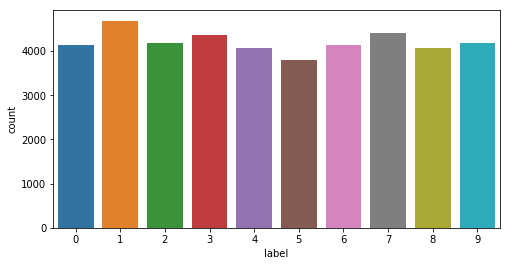

In [12]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=train);

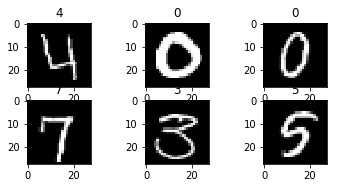

In [13]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(3, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [14]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [15]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

## 4. Data Preprocessing

#### Feature Standardization
It is important preprocessing step. It is used to centre the data around zero mean and unit variance.

In [16]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

### ***One Hot encoding of labels.***
A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension.

For example, 3 would be [0,0,0,1,0,0,0,0,0,0].

In [17]:
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

Let's plot 10th label.

/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


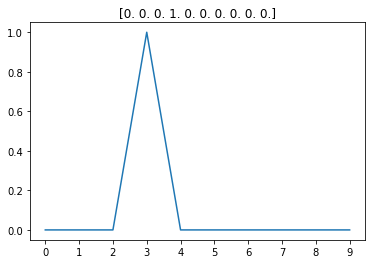

In [18]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

## 5. Designing Neural Network Architecture

In [19]:
# fix random seed for reproducibility
seed = 10
np.random.seed(seed)

In [20]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

In [21]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


### Compile network
Before making network ready for training we have to make sure to add below things:

A loss function: to measure how good the network is

An optimizer: to update network as it sees more data and reduce loss value

Metrics: to monitor performance of network

In [22]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [23]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

### Cross Validation

In [24]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=10)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [25]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3
33600/33600 [==============================] - 99s 3ms/step - loss: 0.2396 - acc: 0.9336 - val_loss: 0.3134 - val_acc: 0.9152
Epoch 2/3
33600/33600 [==============================] - 99s 3ms/step - loss: 0.2125 - acc: 0.9421 - val_loss: 0.3319 - val_acc: 0.9135
Epoch 3/3
33600/33600 [==============================] - 100s 3ms/step - loss: 0.2055 - acc: 0.9443 - val_loss: 0.3550 - val_acc: 0.9101


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

## Convolutional Neural Network (CNN)

In [27]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [28]:
model= get_cnn_model()
model.optimizer.lr=0.01

In [29]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
11957/33600 [=========>....................] - ETA: 27:30 - loss: 0.0822 - acc: 0.9773

## Adding Batch Normalization

In [30]:
from keras.layers.normalization import BatchNormalization

def get_bn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [31]:
model= get_bn_model()
model.optimizer.lr=0.01
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
11861/33600 [=========>....................] - ETA: 36:40 - loss: 0.0366 - acc: 0.9898

### Submitting Predictions to Kaggle.

In [32]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator()
batches = gen.flow(X, y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)

Epoch 1/3
11923/42000 [=======>......................] - ETA: 51:14 - loss: 0.0312 - acc: 0.9970

In [33]:
predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("Digit_Recog.csv", index=False, header=True)